In [1]:
# illustration of multi-stakeholder optimization problem
# victor m. zavala, 2017

using JuMP 
using Ipopt 
using PyPlot

# number of objectives
nObj = 2

# number of stakeholders
nStake = 20;

# get weights and normalize them
W = rand(nStake,nObj)
for i = 1:size(W,1)
W[i,:] = W[i,:] / sum(W[i,:])
end

# container for solutions
f1v=zeros(nStake)
f2v=zeros(nStake)
cp=zeros(nStake)

for p in 1:nStake

# Model 
m = Model(solver=IpoptSolver(print_level=0))

@variable(m, 0 <= x1<= 1)    
@variable(m, 0 <= x2<= 1)  
@variable(m,cost)
@NLconstraint(m, cons, x1^2 + x2 == 1 ) 
@NLconstraint(m,costcons,cost== W[p,1]*(x1-1)^2 + W[p,2]*(x2-x1)^2)
@NLobjective(m, Min,cost)
   
# solve model and get solution
solve(m)
    
# collect solution    
    f1v[p]=(getvalue(x1)-1)^2
    f2v[p]=(getvalue(x2)-getvalue(x1))^2
    cp[p]=getvalue(cost)
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



In [2]:
# Compute compromise solution using cvar
P=1:nStake
alpha=0.1

m = Model(solver=IpoptSolver(tol = 1e-4, max_iter = 100,linear_solver ="mumps",mu_strategy="monotone"))

@variable(m, 0 <= x1<= 1)    
@variable(m, 0 <= x2<= 1)  
@variable(m, phi[P]>=0)
@variable(m, dis[P])
@variable(m, VaR)
@NLconstraint(m, cons, x1^2 + x2 == 1 ) 
@NLconstraint(m,costcons[p in P],dis[p]== W[p,1]*(x1-1)^2 + W[p,2]*(x2-x1)^2-cp[p])
@NLconstraint(m,cvarcons[p in P],dis[p] - VaR <= phi[p])
@NLobjective(m, Min, VaR+(1/(alpha*nStake))*sum(phi[p] for p in P))
   
# solve model and get solution
solve(m)


This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       62
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:       61

Total number of variables............................:       43
                     variables with only lower bounds:       20
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:       21
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

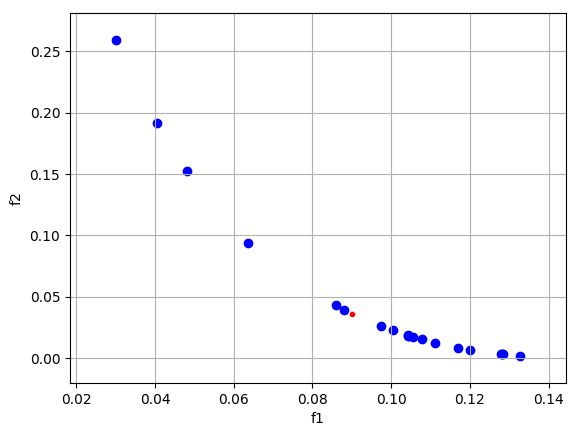

PyObject <matplotlib.text.Text object at 0x7fec1c111490>

In [3]:
cx1=zeros(1)
cx2=zeros(1)
cx1=(getvalue(x1)-1)^2
cx2=(getvalue(x2)-getvalue(x1))^2

# visualize Pareto set and compromise
scatter(f1v,f2v,color="blue",marker="o")
grid("on")
scatter(cx1,cx2,color="red",marker=".")
xlabel("f1")
ylabel("f2")